**Step 1: Data Loading and Exploration**

- Import the neccessary libraries

- Load the heart disease dataset into a Pandas DataFrame.

- Explore the data using methods like head(), info(), and describe() to understand its structure and characteristics.

In [32]:
import pandas as pd # pandas is used to load and manipulate data and for One-Hot Encoding
import numpy as np # numpy is used to calculate the mean and standard deviation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV # this will do cross validation and hyperparameter tuning
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA # to perform PCA to plot the data
import seaborn as sns

In [33]:
df = pd.read_csv('processed.cleveland.data', header=None)

In [34]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


We see that instead of nice column names, we just have column numbers.  Since nice column names would make it easier to know how to format the data, let's replace the column numbers with the following column names:
- **age**,
- **sex**,
- **cp**, chest pain
- **restbp**, resting blood pressure (in mm Hg)
- **chol**, serum cholesterol in mg/dl
- **fbs**, fasting blood sugar
- **restecg**, resting electrocardiographic results
- **thalach**,  maximum heart rate achieved
- **exang**, exercise induced angina
- **oldpeak**, ST depression induced by exercise relative to rest
- **slope**, the slope of the peak exercise ST segment.
- **ca**, number of major vessels (0-3) colored by fluoroscopy
- **thal**, this is short of thalium heart scan.
- **hd**, diagnosis of heart disease, the predicted attribute

In [35]:
df.columns = ['age',
              'sex',
              'cp',
              'restbp',
              'chol',
              'fbs',
              'restecg',
              'thalach',
              'exang',
              'oldpeak',
              'slope',
              'ca',
              'thal',
              'hd']
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


**Step 2: Exploratory Data Analysis (EDA)**

- Conduct exploratory data analysis to gain insights into the data's distribution and relationships.

- Visualize data using histograms, scatter plots, and correlation matrices.

- Identify patterns and potential insights related to heart disease diagnosis.

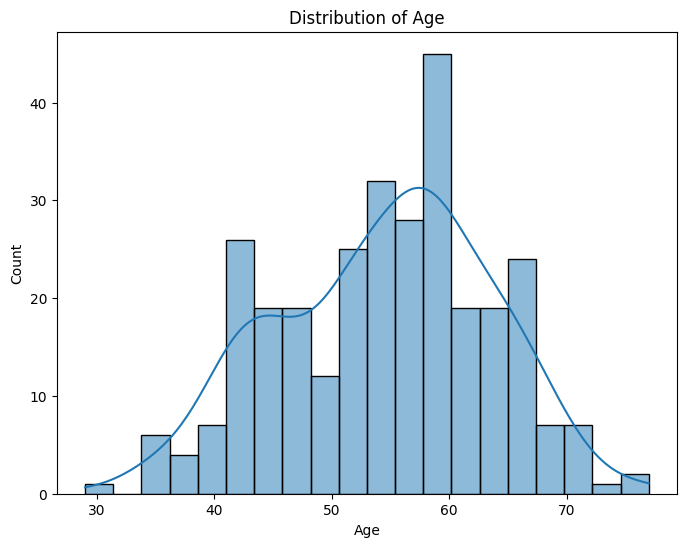

In [36]:
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], kde=True, bins=20)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

**Step 3: Data Preprocessing**

- Handle missing values, if any, by imputing or removing them.

- Encode categorical variables using one-hot encoding or label encoding.

-Remove unnecessary columns that won't be used in the SVM model.

In [37]:
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

We see that that they are almost all `float64`, however, two columns, **ca** and **thal**, have the `object` type and one column, **hd** has `int64`.

The fact that the **ca** and **thal** columns have `object` data types suggests there is something funny going on in them. `object` datatypes are used when there are mixtures of things, like a mixture of numbers and letters. In theory, both **ca** and **thal** should just have a few values representing different categories, so let's investigate what's going on by printing out their unique values. We'll start with **ca**:

In [38]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

We see that **ca** contains numbers (0.0, 3.0, 2.0 and 1.0) and questions marks (?). The numbers represent the number of blood vessels that we lit up by fluoroscopy and the question marks represent missing data.

Now let's look at the unique values in **thal**.

In [39]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

Again, **thal** also contains a mixture of numbers, representing the different diagnoses from the thalium heart scan, and question marks, which represent missing values.

In [40]:
len(df.loc[(df['ca'] == '?') | (df['thal'] == '?')])

6

Since only 6 rows have missing values, let's look at them.

In [41]:
df.loc[(df['ca'] == '?') | (df['thal'] == '?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


Now let's count the number of rows in the full dataset.

In [42]:
len(df)

303

So 6 of the **303** rows, or **2%**, contain missing values. Since **303 - 6 = 297**, and **297** is plenty of data to build a support vector machine, we will remove the rows with missing values, rather than try to impute their values. We do this by selecting all of the rows that do not contain question marks in either the **ca** or **thal** columns:

In [43]:
df_no_missing = df.loc[(df['ca'] != '?') & (df['thal'] != '?')]

In [44]:
len(df_no_missing)

297

In [45]:
X = df_no_missing.drop('hd', axis = 1).copy()

In [46]:
y = df_no_missing['hd'].copy()

In [47]:
X.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
dtype: object

 For the **cp** (chest pain) column, we have 4 options:
1. typical angina,
2. atypical angina,
3. non-anginal pain,
4. asymptomatic

In [48]:
X['cp'].unique()

array([1., 4., 3., 2.])

In [49]:
X_encoded = pd.get_dummies(X, columns=['cp', 'restecg', 'slope', 'thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0


Now, one last thing before we build a Support Vector Machine.  `y` doesn't just contain **0**s and **1**s. Instead, it has **5** different levels of heart disease. **0 =** no heart disease and **1-4** are various degrees of heart disease. We can see this with `unique()`:

In [50]:
y.unique()

array([0, 2, 1, 3, 4])

Since we're only making a support vector machine that does simple classification and only care if someone has heart disease or not, we need to convert all numbers **> 0** to **1**.

In [51]:
y_not_zero_idx = y > 0
y[y_not_zero_idx] = 1
y.unique()

array([0, 1])

**Step 4: Feature Selection (Optional)**

- Choose relevant features for predicting heart disease.

- Consider the impact of each feature on the prediction task.

- Decide whether to use all features or a subset based on domain knowledge.

**Step 5: Data Splitting**

- Split the dataset into training and testing sets to evaluate the model's performance.

- Common splits include 70-30 or 80-20 for training and testing, respectively.

**Step 6: Feature Scaling**

- Standardize or normalize the feature values to ensure they are on the same scale.

- Scaling is essential for SVM as it relies on distances between data points.

The **Radial Basis Function (RBF)** that we are using with our **Support Vector Machine** assumes that the data are centered and scaled, so we need to do this to both the training and testing datasets.

**NOTE:** We split the data into training and testing datasets and then scale them separately to avoid **Data Leakage**. **Data Leakage** occurs when information about the training dataset currupts or influences the testing dataset.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

----

**Step 7: SVM Model Building**

- Create an SVM model for classification.
- Choose the appropriate SVM kernel (e.g., linear, polynomial, or radial basis function).
- Initialize the model with hyperparameters like C (regularization parameter) and kernel-specific parameters.

**Step 8: Model Training**

- Train the SVM model on the training data.
- The model learns to differentiate between patients with and without heart disease based on the features.

In [53]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

**Step 9: Model Evaluation**

- Evaluate the SVM model's performance on the testing data:
- Calculate classification metrics such as accuracy, precision, recall, F1-score, and the confusion matrix.
- Visualize results through ROC curves and precision-recall curves.
Use cross-validation for robust model evaluation.

In [54]:
y_pred = clf_svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        42
           1       0.85      0.85      0.85        33

    accuracy                           0.87        75
   macro avg       0.86      0.86      0.86        75
weighted avg       0.87      0.87      0.87        75



**Step 10: Hyperparameter Tuning**

- Optimize the SVM model's hyperparameters (Gamma, C and kernel parameters) using techniques like grid search or random search to improve model performance.

In [55]:
param_grid = [{'C': [1, 10, 100, 1000],
               'gamma': [0.001, 0.0001],
               'kernel': ['rbf']}]

optimal_params = GridSearchCV(SVC(), param_grid, cv=5, verbose=0)

optimal_params.fit(X_train_scaled, y_train)
optimal_params.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

In [56]:
clf_svm = SVC(random_state=42, C=10, gamma =0.001, kernel='rbf')
clf_svm.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.001, random_state=42)

In [57]:
y_pred = clf_svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        42
           1       0.88      0.88      0.88        33

    accuracy                           0.89        75
   macro avg       0.89      0.89      0.89        75
weighted avg       0.89      0.89      0.89        75



The last thing we are going to do is draw the optimized support vector machine decision boundary and discuss how to interpret it.

The first thing we need to do is count the number of columns in **X**:

In [58]:
len(df.columns)

14

So we see that there are **14** features, or columns, in **X**.
This is a problem because it would require a 14-dimensional graph, one dimension per feature used to make predictions, to plot the data in its raw form. If we wanted to, we could just pick two features at random to use as x and y-axes on our graph, but instead , we will use **PCA** (Principal Component Analysis) to combine the **14** features into **2** orthogonal meta-features that we can use as axes for a graph. If you don't already know about PCA, don't sweat it. For now, just know that it is a way to shrink a 14-dimensional graph into a 2-dimensional graph.

However, before we shrink the graph, let's first determine how accurate the shrunken graph will be. If it's relatively accurate, than it makes sense to draw the 2-Dimensional graph. If not, the shrunken graph will not be very useful. We can determine the accuracy of the graph by drawing something called a **scree plot**.

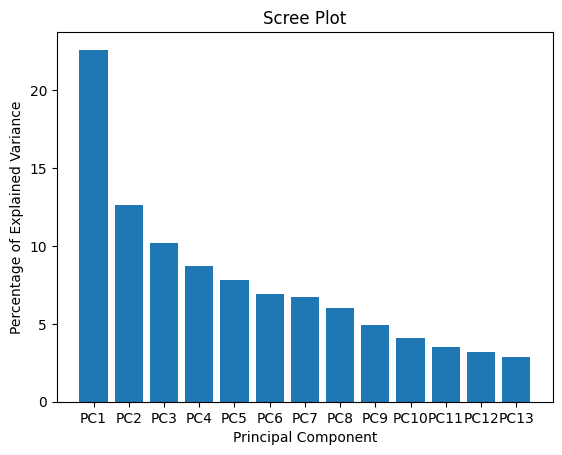

In [59]:
pca = PCA() # By default, PCA() centers the data, but does not scale it.
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

The scree plot shows that the first principal component, PC1, accounts for a relatively large amount of variation in the raw data, and this means that it will be a good candidate for the x-axis in the 2-dimensional graph. Since PC2 accounts for the next largest amount of variance, we will use that for the y-axis.

Now we will draw the PCA graph. NOTE: This code is quite technical, but we don't have to type it in and there are comments that explain each step.

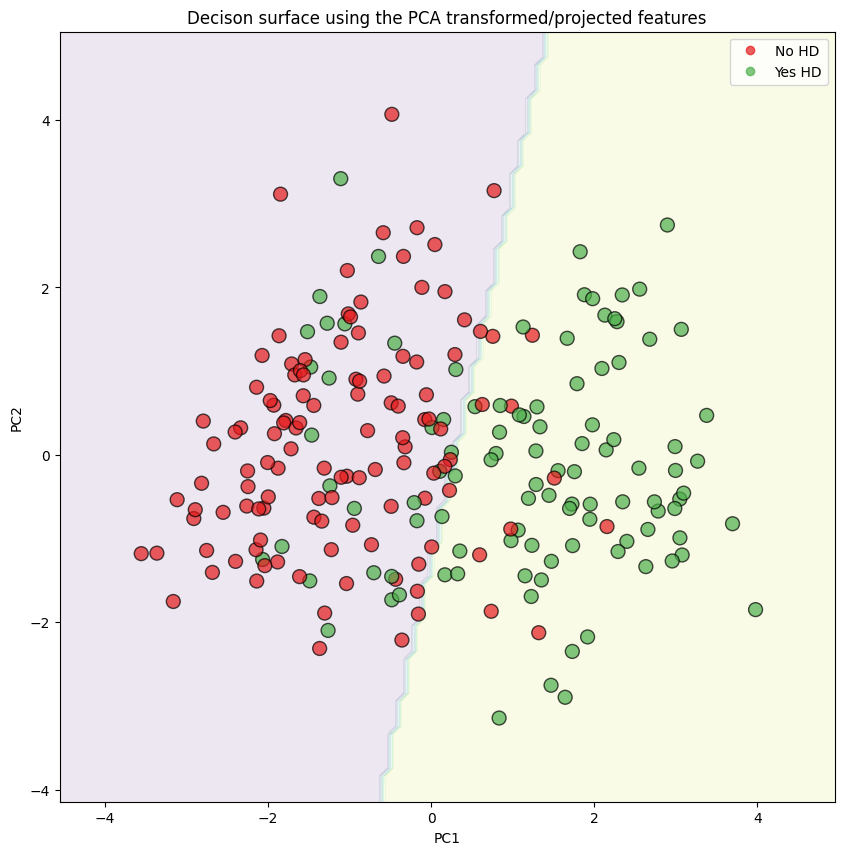

In [60]:
pc1 = X_train_pca[:, 0]
pc2 = X_train_pca[:, 1]

## NOTE:
## pc1 contains the x-axis coordinates of the data after PCA
## pc2 contains the y-axis coordinates of the data after PCA

## Now we fittthe SVM to the x and y-axis coordinates
## of the data after PCA dimension reduction...
clf_svm.fit(np.column_stack((pc1, pc2)), y_train)

## Now create a matrix of points that we can use to show
## the decision regions.
## The matrix will be a little bit larger than the
## transformed PCA points so that we can plot all of
## the PCA points on it without them being on the edge
x_min = pc1.min() - 1
x_max = pc1.max() + 1

y_min = pc2.min() - 1
y_max = pc2.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

## now we will classify every point in that
## matrix with the SVM. Points on one side of the
## classification boundary will get 0, and points on the other
## side will get 1.
Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))
## Right now, Z is just a long array of lots of 0s and 1s, which
## reflect how each point in the mesh was classified.
## We use reshape() so that each classification (0 or 1) corresponds
## to a specific point in the matrix.
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))
## now we will use contourf() to draw a filled contour plot
## using the matrix values and classifications.
## The contours will be filled according to the
## predicted classifications (0s and 1s) in Z
ax.contourf(xx, yy, Z, alpha=0.1)

## now create custom colors for the actual data points
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])
## now darw the actual data points - these will
## be colored by their known (not predcited) classifications
## NOTE: setting alpha=0.7 lets us see if we are covering up a point
scatter = ax.scatter(pc1, pc2, c=y_train,
               cmap=cmap,
               s=100,
               edgecolors='k', ## 'k' = black
               alpha=0.7)

## now create a legend
legend = ax.legend(scatter.legend_elements()[0],
                   scatter.legend_elements()[1],
                    loc="upper right")
legend.get_texts()[0].set_text("No HD")
legend.get_texts()[1].set_text("Yes HD")

## now add axis labels and titles
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decison surface using the PCA transformed/projected features')
# plt.savefig('svm.png')
plt.show()

The pink side of the graph on the left is the area were all datapoints will be predicted to *not have* heart disease. The yellow side of the graph on the right is the area where all datapoints will be predicted to *have* heart disease. The the dots are datapoints in the training dataset and are color coded by their known classifications: red is for those that did *not have* heart disease and green is for those that *did* have heart disease.